## Excersice 3

#### Loading resources

In [1]:
# Loads relevant libraries for excersice
import pandas as pd
import matplotlib

# Loads data from .csv file
hotels = pd.read_csv("hotels_data.csv", low_memory=False)

### Section A

Find 150 hotels which have highest amount of reservations

In [2]:
# Divide data to groups by 'Hotel Name'
hotelsAsGroups = hotels.groupby(['Hotel Name'])

# Count number of reservations with aggregetion
# Then picking an arbitrary column - for working with the counts vector
reservationsCount = hotelsAsGroups.agg(['count'])['Days']

# Sorting and stay with top 150 hotel records
popularHotelsCount = reservationsCount.sort_values(by=['count'], ascending=False).head(150)

# Take only popular hotels data
fHotels = hotels.loc[hotels['Hotel Name'].isin(popularHotelsCount.index)]

In [3]:
popularHotelsCount.count()

count    150
dtype: int64

### Section B

Find from popular 150 hotels the most popular 40 Check-In dates

In [4]:
# Group by check in date
checkInGroups = fHotels.groupby(['Checkin Date'])

# Count number of reservations in each date with aggregetion
# Then picking an arbitrary column - for working with the counts vector
checkInDatesCount = checkInGroups.agg(['count'])['Days']
popCheckInDatesCount = checkInDatesCount.sort_values(by=['count'], ascending=False).head(40)

# Take only popular check-in dates data
fHotels = fHotels.loc[hotels['Checkin Date'].isin(popCheckInDatesCount.index)]

#hotelgrouped = popDatesOnly.groupby(['Hotel Name'])

In [5]:
len(fHotels.groupby(['Checkin Date']))

40

### Section C

Creating DataFrame that saves for each Check-In date, for-each hotel its and for-each discount-code it's price. (if there is no price will be -1)



In [6]:
dateslst = popCheckInDatesCount.index.values

# mapping for each date concat each discount code
codes = [1,2,3,4]
mapDatesWithDiscountCodes = map(lambda date: 
    list(map(lambda code: date + "-" + str(code), codes))
    , dateslst)

# Get it as list, each cell is a list with date-code concating
nestedLst = list(mapDatesWithDiscountCodes)

# Flat data to get only layer of date, again with date-code concat pairs
flatLst = [dateWithCode for dateList in nestedLst for dateWithCode in dateList]

In [7]:
len(flatLst)

160

Sets cluster Data-Frame structure

In [8]:
# Sets a data-frame for saving data
# Record is 'Hotel Name' with all date-code pairs
clusterColumns = ['Hotel Name'] + flatLst
cluster = pd.DataFrame(columns=clusterColumns)

Fill cluster Data-Frame data

In [9]:
cHotelRecords = fHotels.groupby(['Hotel Name'])

# Iterate each grouped hotel
for htlName, htlGroup in cHotelRecords:
    
    # Init new row
    clusterRow = {'Hotel Name': htlName}
    
    currDateGrouped = htlGroup.groupby(['Checkin Date'])
    
    for chkName, chkGroup in currDateGrouped:
        
        dCodeGrouped = htlGroup.groupby(['Discount Code'])
        
        for dCodeName, dCodeGroup in dCodeGrouped:
            
            # Gets lowest price from the same hotel with same discount code
            # on the same date
            rowIdx = dCodeGroup['Discount Price'].idxmin(axis=1)
            lowPrice = dCodeGroup.loc[rowIdx]['Discount Price']
            # Sets that price
            clusterRow[chkName + "-" + str(int(dCodeName))] = lowPrice
    
    # Appending cluster Data-Frame
    cluster = cluster.append(clusterRow, ignore_index=True)

# Fill empty cells with default value [-1]
cluster = cluster.fillna(-1)

## Section D
Normalization

In [10]:
import math

# Normalize according to price range [between 0-100]
def normalize(maxVal, minVal, val):
    if (maxVal == minVal):
        return 100
    else:
        return (float(val - minVal) / (maxVal - minVal)) * 100

# Drops string columns for normalization 
norCluster = cluster.drop('Hotel Name', axis=1)

# Go over rows and normalize each one:
for rowIdx, row in  norCluster.iterrows():
    
    # Reset current maximum and minimum
    currMax = row.max()
    currMin = currMax
    
    # Finds minimum value
    for col in norCluster:
        
        # Checks if current value is not -1 or lower then the current minimum value
        if row[col] != -1 and row[col] < currMin:
            currMin = row[col]
    
    # Normalize row cells
    cluster.iloc[rowIdx,1:161] = cluster.iloc[rowIdx,1:161].apply(lambda val: -1 if val == -1 else normalize(currMax, currMin, val))

In [11]:
cluster

,Hotel Name,11/11/2015 0:00-1,11/11/2015 0:00-2,11/11/2015 0:00-3,11/11/2015 0:00-4,10/14/2015 0:00-1,10/14/2015 0:00-2,10/14/2015 0:00-3,10/14/2015 0:00-4,11/4/2015 0:00-1,...,11/3/2015 0:00-3,11/3/2015 0:00-4,8/13/2015 0:00-1,8/13/2015 0:00-2,8/13/2015 0:00-3,8/13/2015 0:00-4,11/25/2015 0:00-1,11/25/2015 0:00-2,11/25/2015 0:00-3,11/25/2015 0:00-4
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,67.532468,71.428571,0.000000,100.000000,...,71.428571,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000,100.000000,...,-1.000000,-1.000000,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000
2,Andaz Wall Street - a concept by Hyatt,100.000000,52.631579,0.000000,92.105263,100.000000,52.631579,0.000000,92.105263,100.000000,...,0.000000,92.105263,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,52.631579,0.000000,92.105263
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,86.816720,36.012862,100.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,76.923077,0.000000,15.384615,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,44.018059,0.000000,93.679458,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,35.897436,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000,-1.000000,...,100.000000,100.000000,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000


## Section E

Clustering Visualization - dendrogram

In [12]:
norCluster = cluster.drop('Hotel Name', axis=1)

Populating the interactive namespace from numpy and matplotlib


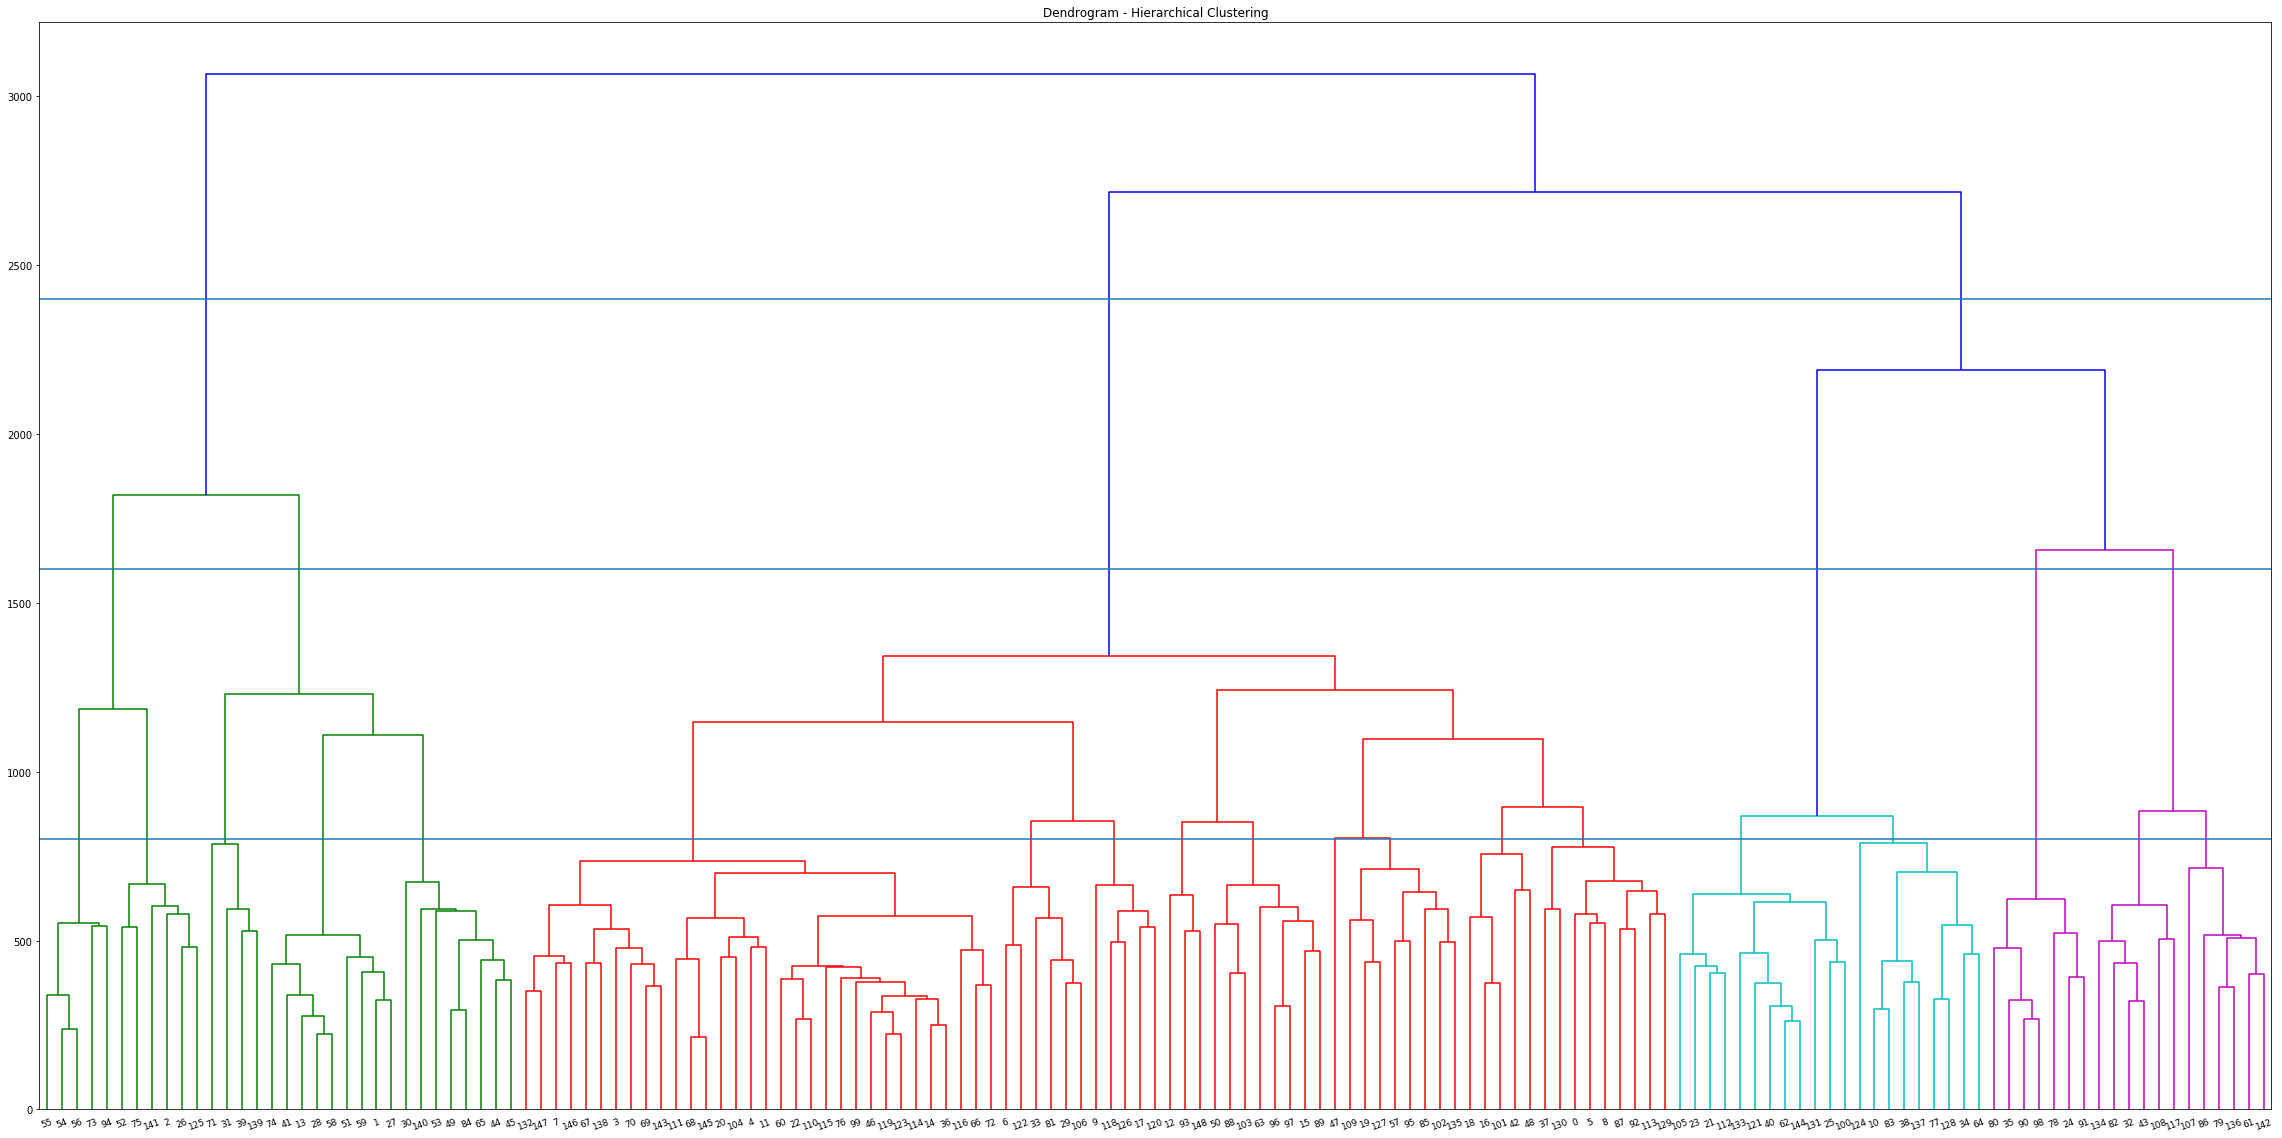

In [17]:
%pylab inline
pylab.rcParams['figure.figsize'] = (40, 20)

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


linkage_matrix = linkage(norCluster, 'ward')
dendrogram(
    linkage_matrix,
    truncate_mode="lastp",  # display last p merged clusters
    p=149,                  # display last p merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts, others idxs
    leaf_rotation=20.,
    leaf_font_size=9.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Dendrogram - Hierarchical Clustering')
plt.axhline(y=2400)
plt.axhline(y=1600)
plt.axhline(y=800)
plt.show()

#### Findings from Dendrogram
We have 4 main clusters, each one has many similatities between them.

**Green cluster**  - Many of the cluster's hotels are Hilton hotels.

**Red cluster**    - Largest group by far (more than twice in size) - Large variance of samples.

**Blue cluster**   - 

**Purple cluster** - Most are at least 4 stars hotels
In the red cluster you have many CourtYard and Hampton hotels - could be because it is the biggest group - it also had a very large variance in data.
Most of the purple clusters hotels have at least 4 stars in them (excluding 3 hotels out of 19 hotels in general)
In general, you could use this information to compare different hotels' pricing conventions. for example - If you would like to go on a vacation on specific date, but the discounted price is too high, you could follow this algorithm and find out which other hotel has the same pricing convention but at a lower cost (since the data has been normalized).

In [14]:
cluster.head(65)

,Hotel Name,11/11/2015 0:00-1,11/11/2015 0:00-2,11/11/2015 0:00-3,11/11/2015 0:00-4,10/14/2015 0:00-1,10/14/2015 0:00-2,10/14/2015 0:00-3,10/14/2015 0:00-4,11/4/2015 0:00-1,...,11/3/2015 0:00-3,11/3/2015 0:00-4,8/13/2015 0:00-1,8/13/2015 0:00-2,8/13/2015 0:00-3,8/13/2015 0:00-4,11/25/2015 0:00-1,11/25/2015 0:00-2,11/25/2015 0:00-3,11/25/2015 0:00-4
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,67.532468,71.428571,0.000000,100.000000,...,71.428571,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000,100.000000,...,-1.000000,-1.000000,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000
2,Andaz Wall Street - a concept by Hyatt,100.000000,52.631579,0.000000,92.105263,100.000000,52.631579,0.000000,92.105263,100.000000,...,0.000000,92.105263,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,52.631579,0.000000,92.105263
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,86.816720,36.012862,100.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,76.923077,0.000000,15.384615,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,44.018059,0.000000,93.679458,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,35.897436,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000,-1.000000,...,100.000000,100.000000,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000


In [15]:
cluster

,Hotel Name,11/11/2015 0:00-1,11/11/2015 0:00-2,11/11/2015 0:00-3,11/11/2015 0:00-4,10/14/2015 0:00-1,10/14/2015 0:00-2,10/14/2015 0:00-3,10/14/2015 0:00-4,11/4/2015 0:00-1,...,11/3/2015 0:00-3,11/3/2015 0:00-4,8/13/2015 0:00-1,8/13/2015 0:00-2,8/13/2015 0:00-3,8/13/2015 0:00-4,11/25/2015 0:00-1,11/25/2015 0:00-2,11/25/2015 0:00-3,11/25/2015 0:00-4
0,Aloft Harlem,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,67.532468,71.428571,0.000000,100.000000,...,71.428571,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,Andaz 5th Avenue - a concept by Hyatt,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000,100.000000,...,-1.000000,-1.000000,100.000000,30.639098,28.195489,0.000000,100.000000,30.639098,28.195489,0.000000
2,Andaz Wall Street - a concept by Hyatt,100.000000,52.631579,0.000000,92.105263,100.000000,52.631579,0.000000,92.105263,100.000000,...,0.000000,92.105263,-1.000000,-1.000000,-1.000000,-1.000000,100.000000,52.631579,0.000000,92.105263
3,Baccarat Hotel and Residences New York,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,Bentley Hotel,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,86.816720,36.012862,100.000000
5,Best Western Bayside Inn,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,70.689655,100.000000,0.000000,-1.000000
6,Best Western Bowery Hanbee Hotel,-1.000000,-1.000000,-1.000000,-1.000000,76.923077,0.000000,15.384615,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,Best Western Plus Arena Hotel,-1.000000,-1.000000,-1.000000,-1.000000,44.018059,0.000000,93.679458,100.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,Best Western Plus Newark Airport West,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,35.897436,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,Blakely New York,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000,-1.000000,...,100.000000,100.000000,-1.000000,-1.000000,-1.000000,-1.000000,98.913043,0.000000,100.000000,100.000000


In [16]:
hotels.where(lambda x: x['Hotel Name'].any('The Towers of the Waldorf Astoria New York','W New York')).dropna()

ValueError: No axis named The Towers of the Waldorf Astoria New York for object type <class 'pandas.core.series.Series'>

In [ ]:
hotels.where(lambda x: x['Hotel Name'] == 'Hilton Newark Airport').dropna()

In [ ]:
hotels.where(lambda x: x['Hotel Name'] == 'Westin New York at Times Square').dropna()